# Imports

Following this tutorial for using kaggle with colab: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.

Following this tutorial for the data processing: https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432

Repo for above ^ tutorial: https://github.com/JadeBlue96/DCGAN-Dog-Generator.git

In [1]:
#!pip install keras==2.3.1 # https://stackoverflow.com/questions/63062833/no-module-named-keras-legacy?scrlybrkr
#!pip install tensorflow==2.1.0 # https://stackoverflow.com/questions/61137954/attributeerror-module-tensorflow-python-keras-utils-generic-utils-has-no-attr

In [2]:
!pip install kaggle # will be using the stanford dogs dataset with kaggle 

In [3]:
import numpy as np # for np arrays
import matplotlib.pyplot as plt, zipfile # creating plots

from pathlib import Path # directories as OOP
import os # file reading
import xml.etree.ElementTree as ET # for parsing annotations 
import cv2 # for reading the image

import math
import random

import time
import datetime

from tqdm import tqdm, tqdm_notebook # progress bar

import tensorflow as tf # for the model

import json # for keras api key

# Setting up Keras

In [4]:
!ls -a

.   all-dogs	  Annotation	  .config  __MACOSX
..  all-dogs.zip  Annotation.zip  .kaggle  sample_data


In [5]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.   all-dogs	  Annotation	  .config  __MACOSX
..  all-dogs.zip  Annotation.zip  .kaggle  sample_data


In [6]:
username = "flynnick"
api_key = "74bc7ceb6d32c60199e4f43c993fd206"

token = {"username": username,"key": api_key} # secret

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [7]:
!chmod 600 /content/.kaggle/kaggle.json # read + write allowed

In [8]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [10]:
!kaggle competitions download -c generative-dog-images -p /content # download stanford dog dataset

Annotation.zip: Skipping, found more recently modified local copy (use --force to force download)
all-dogs.zip: Skipping, found more recently modified local copy (use --force to force download)


# Data preparation

In [12]:
!unzip \*.zip # unzip dataset

Archive:  Annotation.zip
replace Annotation/n02097658-silky_terrier/n02097658_98? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
!ls -a

.   all-dogs	  Annotation	  .config  __MACOSX
..  all-dogs.zip  Annotation.zip  .kaggle  sample_data


In [14]:
img_width = 64 # width we will be resizing images to
img_height = 64 # height we will be resizing images to
img_color_channels = 3 # rgb
img_sample_size = 10000
img_output_dir = '/output_images/'
img_input_dir = '/content/all-dogs/'
img_ann_dir = "/content/Annotation/"
OUT_DIR = Path('/output_images/')
TRAIN_DIR = Path('/content/all-dogs')

In [15]:
dog_breed_dict = {}
for annotation in os.listdir(img_ann_dir):
  # annotations follow the format:
  # image_name-breed_name
  annotations = annotation.split('-')
  dog_breed_dict[annotations[0]] = annotations[1]

In [16]:
print(dog_breed_dict)

{'n02088094': 'Afghan_hound', 'n02094258': 'Norwich_terrier', 'n02096585': 'Boston_bull', 'n02097130': 'giant_schnauzer', 'n02105505': 'komondor', 'n02089973': 'English_foxhound', 'n02085782': 'Japanese_spaniel', 'n02101556': 'clumber', 'n02090379': 'redbone', 'n02112137': 'chow', 'n02105056': 'groenendael', 'n02098105': 'soft', 'n02108089': 'boxer', 'n02109525': 'Saint_Bernard', 'n02088632': 'bluetick', 'n02086240': 'Shih', 'n02096177': 'cairn', 'n02111277': 'Newfoundland', 'n02113186': 'Cardigan', 'n02099429': 'curly', 'n02089078': 'black', 'n02116738': 'African_hunting_dog', 'n02110063': 'malamute', 'n02091831': 'Saluki', 'n02105251': 'briard', 'n02100236': 'German_short', 'n02115641': 'dingo', 'n02101006': 'Gordon_setter', 'n02102177': 'Welsh_springer_spaniel', 'n02099601': 'golden_retriever', 'n02110627': 'affenpinscher', 'n02106382': 'Bouvier_des_Flandres', 'n02100877': 'Irish_setter', 'n02089867': 'Walker_hound', 'n02106662': 'German_shepherd', 'n02108551': 'Tibetan_mastiff', 'n

In [17]:
def read_image(img_path):
  '''Reads and transforms an image to RGB.'''
  img = cv2.imread(img_path)
  if img is None:
    raise FileNotFoundError
  else: # technically unnecessary else statement
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [18]:
def load_cropped_images(dog_breed_dict=dog_breed_dict, img_ann_dir=img_ann_dir, sample_size=25000, img_width=img_width, img_height=img_height, img_channels=img_color_channels):
  """
  Loads all the dog images, crops, and resizes them.
  This is the bulk of where the data processing occurs.
  """
  i = 0 # indexing variable
  breeds = []
  # sample size is the number of dogs
  dog_images_np = np.zeros((sample_size, img_width, img_height, img_channels))
  for breed_folder in os.listdir(img_ann_dir):
    for dog_ann in tqdm(os.listdir(img_ann_dir + breed_folder)):
      try:
        img = read_image(os.path.join(img_input_dir, dog_ann + '.jpg')) # read image
      except FileNotFoundError:
        continue
                
      tree = ET.parse(os.path.join(img_ann_dir + breed_folder, dog_ann)) # get the annotations for this image
      root = tree.getroot()
            
      size = root.find('size')
      width = int(size.find('width').text)
      height = int(size.find('height').text)
      objects = root.findall('object')

      for dog in objects: # some images contain multiple dogs, hence objects plural
        bndbox = dog.find('bndbox') # the bounding box around the dog
                
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
                
        xmin = max(0, xmin - 4) # add a margin of 4
        xmax = min(width, xmax + 4) # add a margin of 4
        ymin = max(0, ymin - 4) # add a margin of 4
        ymax = min(height, ymax + 4) # add a margin of 4

        # I am honestly unsure why we are adding a margin of 4, but that is what the code I am following does

        w = np.min((xmax - xmin, ymax - ymin)) # we are cropping these to squares, so we want to use the smaller dimension
        w = min(w, width, height) # this is just to be safe (perhaps the bounding box extends past the image)

        if w > xmax - xmin:
          xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
          xmax = xmin + w
        if w > ymax - ymin:
          ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
          ymax = ymin + w
        
        img_cropped = img[ymin:ymin+w, xmin:xmin+w, :] # [h,w,c]

        # all of the above was to crop the image to just include the dog
        # below is to resize the image to the dimensions we want (img_width and img_height)

        # determine interpolation method
        if xmax - xmin > img_width:
            interpolation = cv2.INTER_AREA # we need to shrink
        else:
            interpolation = cv2.INTER_CUBIC # we need to expand
            
        img_resized = cv2.resize(img_cropped, (img_width, img_height), 
                                interpolation=interpolation) # resize image
            
        dog_images_np[i,:,:,:] = np.asarray(img_resized)
        # annotations follow the format:
        # image_name-breed_name
        dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]] # get the breed name using the image name
        breeds.append(dog_breed_name)
        i += 1
                
  return dog_images_np, breeds

In [25]:
start = time.time()
# the person who did this originally found there to be exactly 22125 dogs
# which helps in creating our np array of fixed size
print("LOADING IMAGES...")
dog_images_np, breeds = load_cropped_images(sample_size=22125)
# dog_images_np is the input data, breeds are the labels we are trying to predict
rounded_time = round(time.time() - start)
print(f"\nImage loading, cropping, and resizing time: {datetime.timedelta(seconds=rounded_time)}.")

LOADING IMAGES...


100%|██████████| 206/206 [00:00<00:00, 206.57it/s]



Image loading, cropping, and resizing time: 0:01:55.


In [20]:
def plot_features(features, labels, img_width=img_width, img_height=img_height, img_channels=img_color_channels, examples=16, disp_labels=True): 
  """Plots some dog images and their corresponding breeds."""
  if not math.sqrt(examples).is_integer():
    print('Please select a valid number of examples (must be a perfect square).')
    return
  imgs = []
  classes = []
  for i in range(examples):
    rnd_idx = np.random.randint(0, len(labels))
    imgs.append(features[rnd_idx, :, :, :])
    classes.append(labels[rnd_idx])

  fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)), figsize=(15,15),
  subplot_kw = {'xticks':[], 'yticks':[]},
  gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
  for i, ax in enumerate(axes.flat):
    if disp_labels == True:
      ax.title.set_text(classes[i])
    ax.imshow(imgs[i])

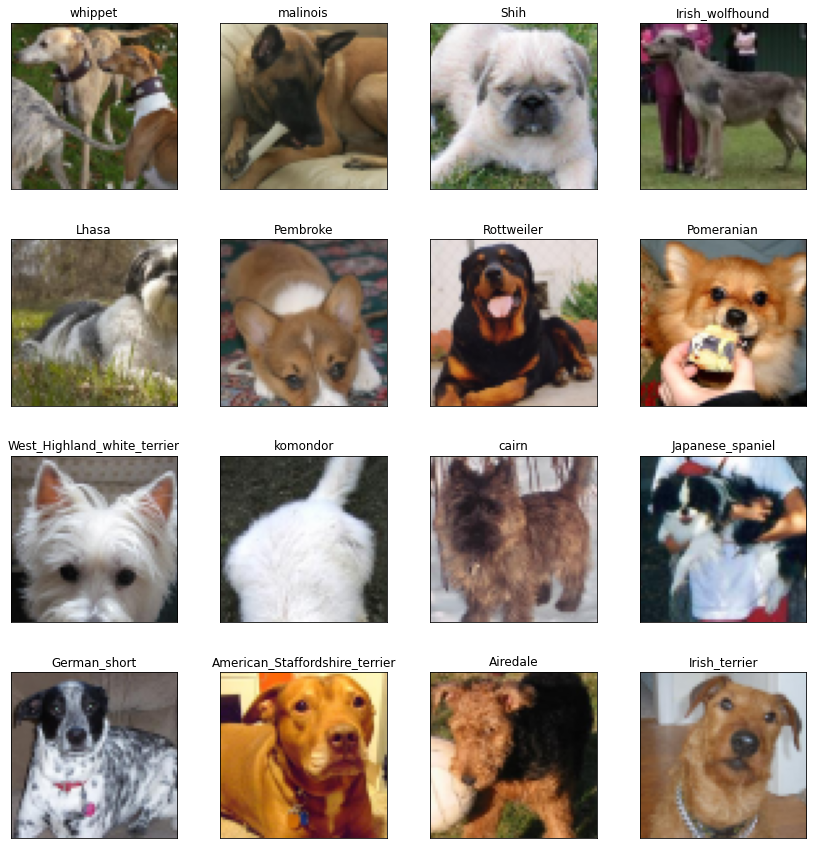

In [21]:
plot_features(dog_images_np / 255., breeds, examples=16, disp_labels=True)

# NOTE: dog_images_np / 255. normalizes the pixel range to [0, 1]

# Something else to note is that because we are cropping the images into squares,
# sometimes we only get part of the dog,
# like only the butt of the komondor below

In [26]:
sample_size = 22125
batch_size = 128


dog_images_np = (dog_images_np - (255/2)) / (255/2)  # normalize the pixel range to [-1, 1], because I will be using tanh for my output, which has the range [-1, 1]

dog_features_tf = tf.cast(dog_images_np, 'float32') # create tf dataset object

# some data augmentation
def flip(x: tf.Tensor) -> (tf.Tensor):
    x = tf.image.random_flip_left_right(x) # 50% img will be flipped
    return x

# shuffle, flip 50% of images, and separate into batches
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(sample_size).map(flip).batch(batch_size, drop_remainder=True)

# Model building

In [38]:
# Necessary tf imports

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

In [33]:
# a bunch of hyperparameters that were pretuned (some of these are for the generator, some for the descriminator)

sample_size = 22125 # number of images
batch_size = 128

weight_init_std = 0.02 # for "stabalizing model training"
weight_init_mean = 0.0 # for "stabalizing model training"

leaky_relu_slope = 0.2

dropout_rate = 0.5

downsize_factor = 2
scale_factor = 4 ** downsize_factor # reshapes generator's noise vector to (4, 4, 512)

# params for learning rate
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000

noise_dim = 128

In [34]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

In [42]:
def DogGenerator():
  model = Sequential()
  model.add(Dense(img_width // scale_factor * img_height // scale_factor * 128, input_shape=(noise_dim,), kernel_initializer=weight_initializer))
  model.add(Reshape((img_height // scale_factor, img_width // scale_factor, 128)))
    
  model.add(Conv2DTranspose(512, kernel_size=5, strides=1))
  model.add(Dropout(dropout_rate))
  model.add(Conv2DTranspose(256, kernel_size=5, strides=2))
  model.add(Dropout(dropout_rate))
  model.add(Conv2DTranspose(128, kernel_size=5, strides=2))
  model.add(Conv2DTranspose(64, kernel_size=5, strides=2))
  model.add(Conv2DTranspose(32, kernel_size=5, strides=2))
    
  model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))

  return model

In [43]:
dog_generator = DogGenerator()
print(dog_generator.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         1638912   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 19, 19, 256)       3277056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 19, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 41, 41, 128)      

Just as a sanity check, it makes sense that the final output has the dimensions (None, 173, 173, 3), because of the previous normalization in data preparation and the 3 channels for RGB.